# The Voice - V3 (Stereo Cut)

In [342]:
using WAV
using TestImages
using FileIO
using Images
using ImageCore
using ImageContrastAdjustment

In [356]:
function scale(line, scalling_factor)
    new_line = []
    for i = 1:size(line)[1]
        to_add = fill(line[i], scalling_factor)
        append!(new_line, to_add)
    end
    return(new_line)
end

scale (generic function with 1 method)

In [357]:
# Function that generates a sound wave given a data line

function getPiste(line, index, bitrate, duration, mode)
    size_data = size(line)[1]
    fs = bitrate # Nombre de data
    duration = Float32(duration)
    t = 0.0:1/fs:prevfloat(duration) # Calcule la range de temps 
    f = (2600 - index*size_data) # Fréquence du signal
    if mode == "sin"
        y = sin.(2pi * f * t) * 0.1
    elseif mode == "squ"
        y = sign.(sin.(2pi * f * t) * 0.1)
    elseif mode == "tri"
        p = 1/f
        y = 2 * abs.((t/p) .- floor.((t/p) .+ (1/2)))
    end
    
    scalling_factor = floor(Int, fs*duration/size_data)
    new_line = scale(line, scalling_factor)
    piste = y .* new_line
end

getPiste (generic function with 2 methods)

In [358]:
function getImg(img_path, inverse_contrast, bins::Integer)
    img = load(img_path)
    # On resize l'image
    size_img = 50
    img_res = imresize(img, (size_img, size_img));

    gray_img = Gray.(img_res) # Create a grey version

    alg = Equalization(nbins = bins) # initialise l'équal avec 2 valeur possibles
    contrast_img = adjust_histogram(gray_img, alg)

    # On inverse le contraste

    if inverse_contrast

        for i = 1:size(contrast_img)[1]
            for j = 1:size(contrast_img)[2]
                contrast_img[i, j] = abs(1 - contrast_img[i, j])
            end
        end
    end

    return(contrast_img)
end

getImg (generic function with 3 methods)

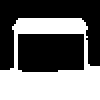

In [366]:
path = "./sample_img/table.jpeg"
path_depth = "./sample_img/table_depth.png"
contrast_img = getImg(path, true, 5)
contrast_img_depth = getImg(path_depth, false, 2)

In [367]:
function getWAV(image, duration, bitrate, mode)

    # On génère la collection de fréquences à ajouter au wav - Coté droit (25 lignes sup)

    number_data = floor(Int, bitrate*duration)

    total_signal_D = zeros(number_data)

    for i = 1:floor(Int, size(image)[1]/2)
        line = image[i, :]
        total_signal_D = total_signal_D .+ getPiste(line, i, bitrate, duration, mode)
    end

    # On génère la collection de fréquences à ajouter au wav - Coté gauche (25 lignes inf)

    total_signal_G = zeros(number_data)

    for i = floor(Int, size(image)[1]/2):size(image)[1]
        line = image[i, :]
        total_signal_G = total_signal_G .+ getPiste(line, i, bitrate, duration, mode)
    end

    # On ajoute toutes les pistes, et on scale de -1 à 1

    clean_signal_D = Float32.(total_signal_D)/50
    clean_signal_G = Float32.(total_signal_G)/50

    all_values = [clean_signal_D; clean_signal_G]
    max_signal = findmax(all_values)[1]

    scaled_signal_D = clean_signal_D .* 1/max_signal
    scaled_signal_G = clean_signal_G .* 1/max_signal

    return([scaled_signal_D scaled_signal_G])
    
end

getWAV (generic function with 2 methods)

In [368]:
duration = 1 # Duration in seconds
bitrate = 8000
mode_contrast = "sin"
mode_depth = "tri"

signal = getWAV(contrast_img, duration, bitrate, mode_contrast)
signal_depth = getWAV(contrast_img_depth, duration, bitrate, mode_depth)
pause = getWAV(contrast_img_depth, 0.3, bitrate, mode_depth) .* 0

total_signal = [signal; pause; signal_depth]

wavplay(total_signal, bitrate)

In [369]:
[signal; signal_depth]

16000×2 Matrix{Float32}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.548287
 0.0  0.610592
 0.0  0.654206
 0.0  0.669782
 0.0  0.638629
 0.0  0.529595
 0.0  0.397196
 0.0  0.264798
 0.0  0.132399

In [370]:
sign(-2.2)

-1.0

## Generate a plot

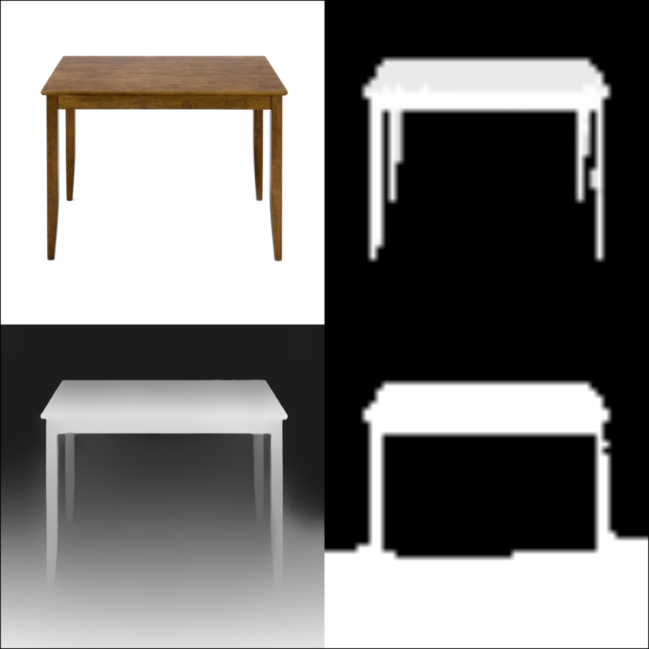

In [371]:
img1 = load(path)
low_size = size(img1)[1]
img1 = imresize(img1, (low_size, low_size))

img_depth = load(path_depth)
img_depth = imresize(img_depth, (low_size, low_size))

contrast_img = imresize(contrast_img, (low_size, low_size))
contrast_img_depth = imresize(contrast_img_depth, (low_size, low_size))

mosaic(img1, img_depth, contrast_img, contrast_img_depth; nrow=2)

In [372]:
wavwrite(total_signal, "table.wav", Fs = bitrate)